## Notebook for assigning cell types to clusters after manual annotation

In [1]:
import scanpy as sc
import numpy as np
from tqdm.notebook import tqdm
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scvi
import glob

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
sc.set_figure_params(figsize=(4, 4))
### Path to the MERSCOPE object from the previous script.
input_folders = '/projects/2023_Spatial_Paper/Analysis_Alex/merscope_final/analysis/final/integrated_clustered.h5ad'
merscope = sc.read(input_folders)
### Path to the Xenium final object after replicate 2 processing
input_folders_x = '/mnt/sata1/Analysis_Alex/timecourse_replicates/analysis/cleaned/full_xenium_replicates_and_reference.h5ad'
types = sc.read(input_folders_x)

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


### Getting the celltype heirarchies from the Xenium data

In [4]:
types_ = pd.crosstab(types.obs['Type'], types.obs['Subtype'])
class_ = pd.crosstab(types.obs['Class'], types.obs['Type'])
immuno_ = pd.crosstab(types.obs['Immunocentric_Type'], types.obs['Subtype'])

#### Reading in a csv file with manual annotations of the sub-Leiden clusters that we derived through an ensembl of methods and manual annotation

In [8]:
celllabels=pd.read_csv('merscope_annotations.csv', index_col=0)
celltypes = []
for i in merscope.obs['Sub_leiden'].values:
    celltypes.append(celllabels.loc[i].values[0])
merscope.obs['Subtype'] = celltypes

### Fixing nomenclature of the Subtype annotations

In [9]:
merscope.obs['Subtype'] = pd.Categorical(merscope.obs['Subtype'].values)

In [10]:
merscope.obs['Subtype'] = merscope.obs['Subtype'].replace('Enterocyte 1', 'Enterocyte_1').replace('Enterocyte 2', 'Enterocyte_2').replace('Enterocyte 3', 'Enterocyte_3')
merscope.obs['Subtype'] = merscope.obs['Subtype'].replace('Eosinophils', 'Eosinophil')
merscope.obs['Subtype'] = merscope.obs['Subtype'].replace('Fibroblast_Pdgfrb+', 'Fibroblast_Pdgfrb+ ')
merscope.obs['Subtype'] = merscope.obs['Subtype'].replace('Resting_Fibroblast', 'Resting Fibroblast')

### Fixing nomenclature of type and class annotations.

In [14]:
types_flip = types_.T
types_flip['Unknown'] = 0
types_ = types_flip.T

In [15]:
types_['Unknown_1'] = [0 if i != 'Unknown' else 1 for i in types_.index.values]
types_['Unknown_2'] = [0 if i != 'Unknown' else 1 for i in types_.index.values]

In [16]:
class_flip = class_.T
class_flip['Unknown'] = 0
class_ = class_flip.T

In [17]:
class_['Unknown'] = [0 if i != 'Unknown' else 1 for i in class_.index.values]

In [18]:
types_['Fibroblast_Apoe+'] = [0 if i != 'Fibroblast' else 1 for i in types_.index.values]

### Final annotation placement and plotting

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = 

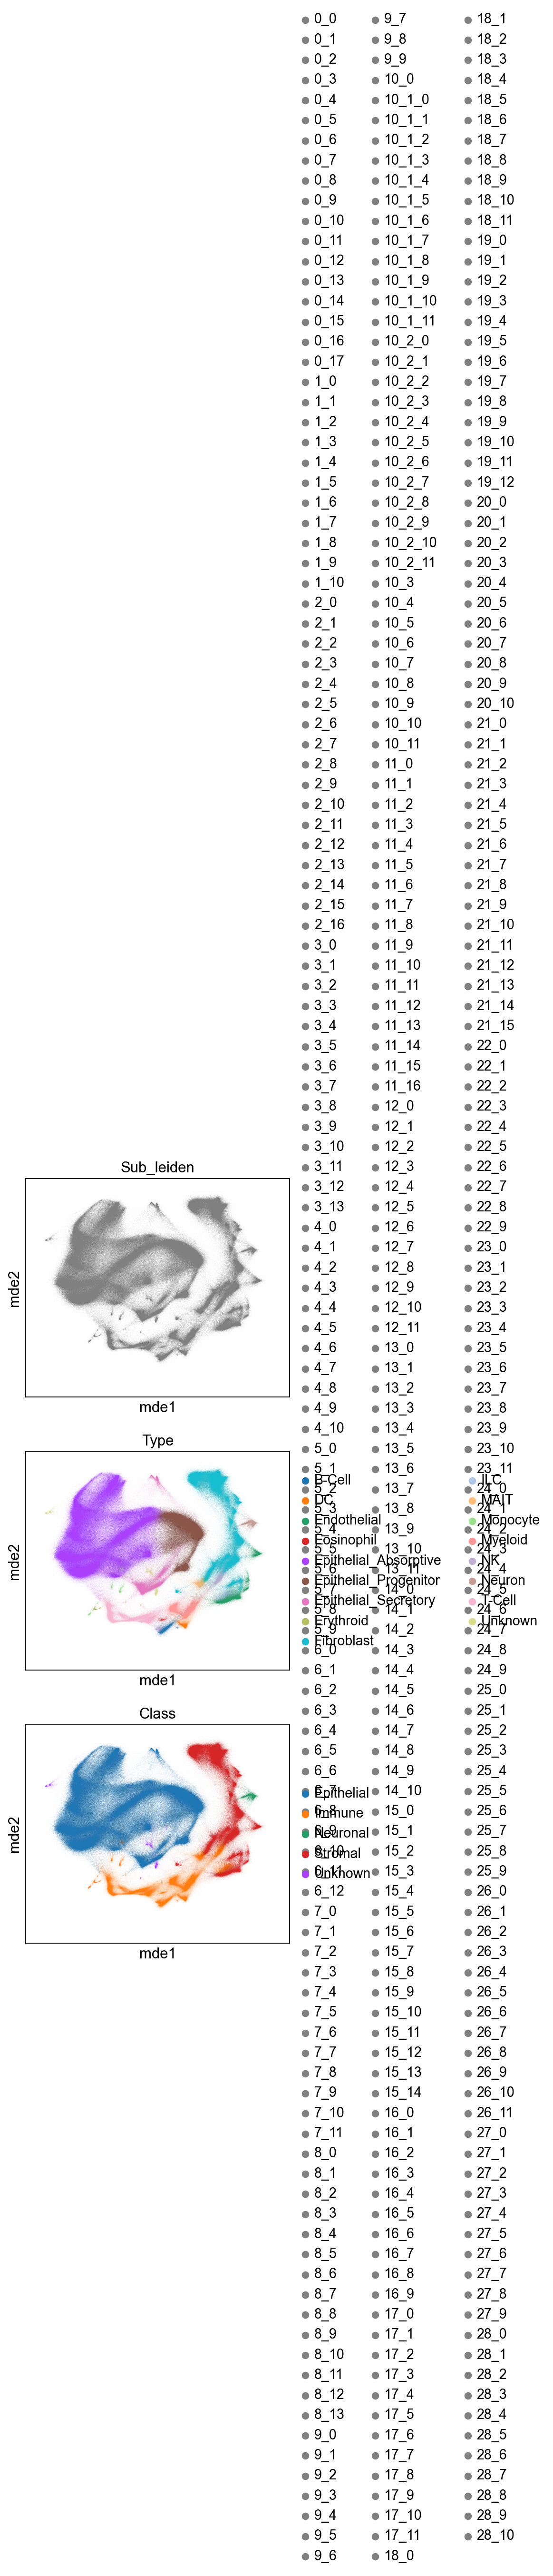

In [19]:

xenium.obs['indices'] = [i for i in range(len(xenium.obs.index))]

type_dictionary = {}
for i in merscope.obs['Subtype'].cat.categories:
    type_dictionary[i] = types_.index.values[np.where(types_[i].values > 0)[0]][0]
all_types = []
for k in merscope.obs['Subtype'].values:
    all_types.append(type_dictionary.get(k))
merscope.obs['Type'] = all_types

itype_dictionary = {}
for i in merscope.obs['Subtype'].cat.categories:
    try:
        itype_dictionary[i] = immuno_.index.values[np.where(immuno_[i].values > 0)[0]][0]
    except:
        itype_dictionary[i] = 'None'
all_itypes = []
for k in merscope.obs['Subtype'].values:
    all_itypes.append(itype_dictionary.get(k))
merscope.obs['Immunocentric_Type'] = all_itypes

class_dictionary = {}
for i in np.unique(merscope.obs['Type'].values):
    class_dictionary[i] = class_.index.values[np.where(class_[i].values > 0)[0]][0]
all_classes = []
for k in merscope.obs['Type'].values:
    all_classes.append(class_dictionary.get(k))
merscope.obs['Class'] = all_classes

sc.pl.embedding(merscope, basis='mde', color=['Sub_leiden', 'Type', 'Class'], ncols=1)

### Write out the data at the desired path

In [21]:
merscope.write('/projects/2023_Spatial_Paper/Analysis_Alex/merscope_final/analysis/final/full_celltypes_and_leiden.h5ad')